# Import Library & Dataset

In [ ]:
import gdown
import zipfile

In [ ]:
# URL dari Google Drive
url = "https://drive.google.com/uc?export=download&id=1STlbfWBiwl-rD-kmLh9k686cP_b7b4R9"
output = "Audio_Speech_Actors_01-24.zip"

# Unduh file ZIP
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1STlbfWBiwl-rD-kmLh9k686cP_b7b4R9
From (redirected): https://drive.google.com/uc?export=download&id=1STlbfWBiwl-rD-kmLh9k686cP_b7b4R9&confirm=t&uuid=6569f8ac-00d8-48cb-ba3c-c01bcef53470
To: /content/Audio_Speech_Actors_01-24.zip
100%|██████████| 208M/208M [00:03<00:00, 61.3MB/s]


'Audio_Speech_Actors_01-24.zip'

In [ ]:
extract_path = "speech_dataset"

with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
import pandas as pd
import seaborn as sns
from IPython.display import Audio, display
from collections import defaultdict
from scipy.io import wavfile
import sklearn.metrics as metrics

# Exploratory Data Analysis (EDA)

In [ ]:
audio_files = glob.glob(os.path.join(extract_path, "Actor_*/*.wav"))

In [ ]:
# Parsing metadata dari nama file
data_records = []
for file in audio_files:
    fname = os.path.basename(file).split('.')[0]
    parts = fname.split('-')
    emotion = int(parts[2])
    intensity = int(parts[3])  # 1 = normal, 2 = strong
    statement = int(parts[4])  # 1 atau 2
    actor_id = int(parts[-1])
    gender = 'male' if actor_id % 2 == 1 else 'female'
    data_records.append({
        "file": file,
        "actor_id": actor_id,
        "emotion": emotion,
        "intensity": intensity,
        "statement": statement,
        "gender": gender
    })

df = pd.DataFrame(data_records)

In [ ]:
emotion_labels = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust',
    8: 'surprised'
}
df['emotion_label'] = df['emotion'].map(emotion_labels)

## 1. Jumlah file per aktor

Jumlah file per aktor:
actor_id
1     60
2     60
3     60
4     60
5     60
6     60
7     60
8     60
9     60
10    60
11    60
12    60
13    60
14    60
15    60
16    60
17    60
18    60
19    60
20    60
21    60
22    60
23    60
24    60
Name: count, dtype: int64


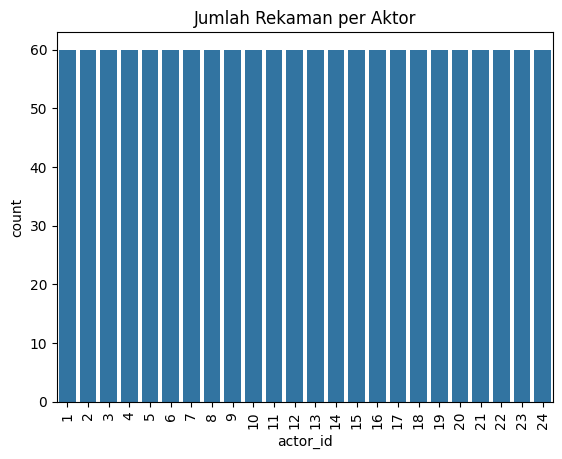

In [ ]:
print("Jumlah file per aktor:")
print(df['actor_id'].value_counts().sort_index())
sns.countplot(data=df, x='actor_id')
plt.title("Jumlah Rekaman per Aktor")
plt.xticks(rotation=90)
plt.show()

## 2. Jumlah file duplikat

In [ ]:
print("Jumlah file duplikat berdasarkan path:")
duplicates = df['file'].duplicated().sum()
print(f"Total duplikat: {duplicates}")

Jumlah file duplikat berdasarkan path:
Total duplikat: 0


## 3. Distribusi emosi berdasarkan gender

Distribusi emosi berdasarkan gender:


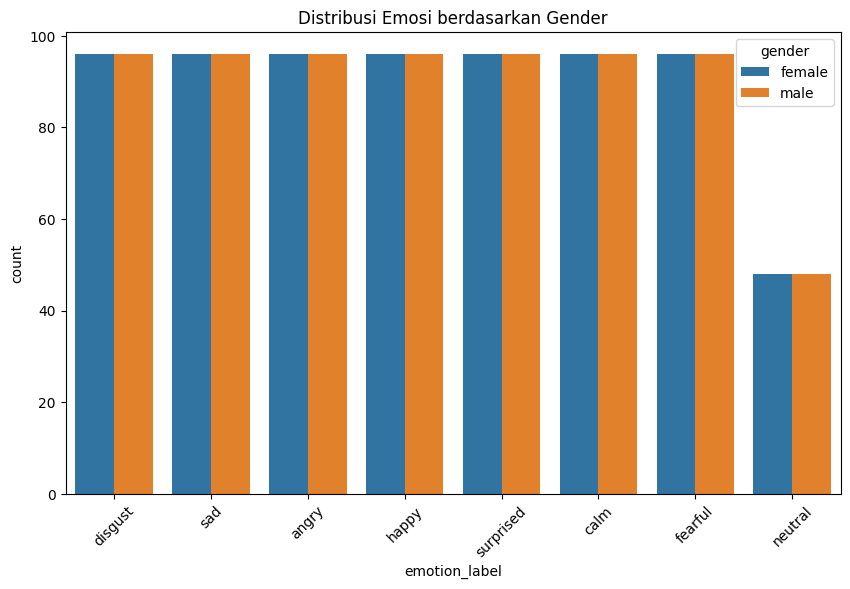

In [ ]:
print("Distribusi emosi berdasarkan gender:")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion_label', hue='gender')
plt.title("Distribusi Emosi berdasarkan Gender")
plt.xticks(rotation=45)
plt.show()

## 4. Distribusi intensitas (normal vs kuat)

Distribusi intensitas emosi:


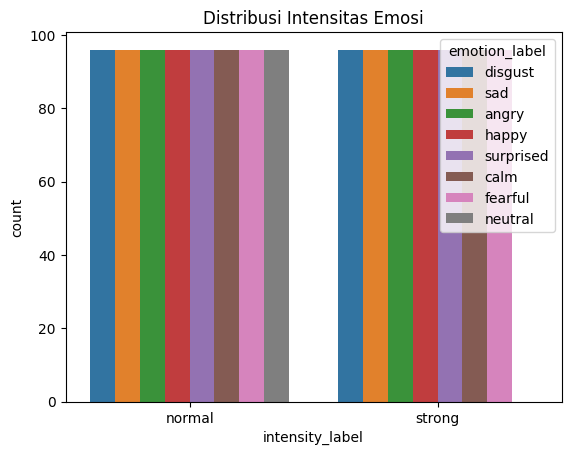

In [ ]:
print("Distribusi intensitas emosi:")
df['intensity_label'] = df['intensity'].map({1: 'normal', 2: 'strong'})
sns.countplot(data=df, x='intensity_label', hue='emotion_label')
plt.title("Distribusi Intensitas Emosi")
plt.xticks(rotation=0)
plt.show()

## 5. Distribusi statement 1 dan 2 untuk tiap emosi

Distribusi statement 1 dan 2:


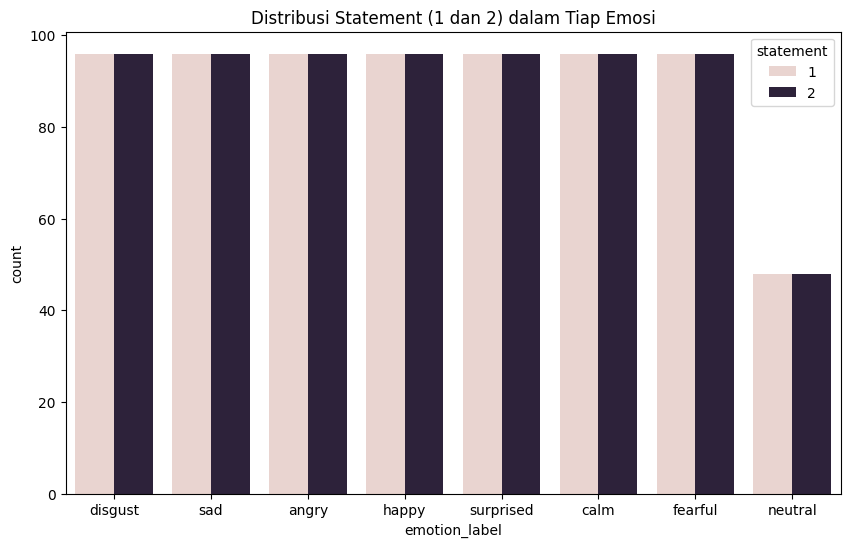

In [ ]:
print("Distribusi statement 1 dan 2:")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion_label', hue='statement')
plt.title("Distribusi Statement (1 dan 2) dalam Tiap Emosi")
plt.show()

## 6. Rata-rata durasi audio

Rata-rata durasi audio:
Durasi rata-rata: 3.70 detik


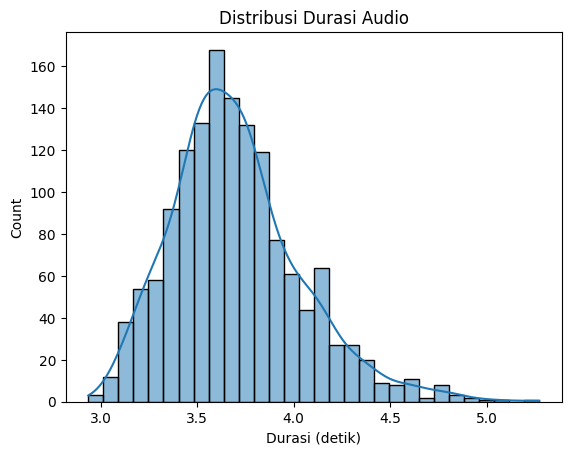

In [ ]:
print("Rata-rata durasi audio:")
durations = []
for file in df['file']:
    data, sr = librosa.load(file, sr=None)
    durations.append(len(data) / sr)
df['duration'] = durations
print(f"Durasi rata-rata: {np.mean(durations):.2f} detik")
sns.histplot(df['duration'], bins=30, kde=True)
plt.title("Distribusi Durasi Audio")
plt.xlabel("Durasi (detik)")
plt.show()

## 7. Cek Sample Rate

Validasi sample rate:
Sample rate unik yang ditemukan: [48000]


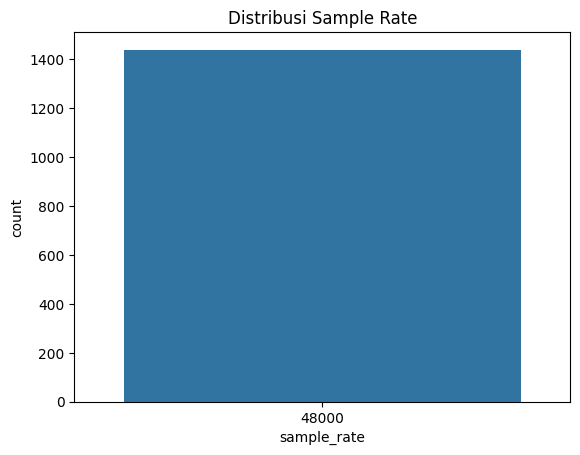

In [ ]:
print("Validasi sample rate:")
sample_rates = []
for file in df['file']:
    sr = librosa.get_samplerate(file)
    sample_rates.append(sr)
df['sample_rate'] = sample_rates
print("Sample rate unik yang ditemukan:", df['sample_rate'].unique())
sns.countplot(x=df['sample_rate'])
plt.title("Distribusi Sample Rate")
plt.show()

# Preprocessing Data

In [ ]:
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [ ]:
def extract_feature(data, sr, mfcc, chroma, mel):

    """
    extract features from audio files into numpy array

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """

    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        # Pass 'data' as the 'y' keyword argument
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))

    return result

In [ ]:
def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [ ]:
def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

In [ ]:
def load_data(save=False, data_directory="speech_dataset"):
    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy
    data_directory : string, path to dataset directory
    """
    x, y = [], []

    # Pastikan direktori dataset ada
    if not os.path.exists(data_directory):
        raise FileNotFoundError(f"Directory '{data_directory}' not found. Please ensure the dataset is extracted correctly.")

    # Cek apakah ada file .wav di direktori
    wav_files = glob.glob(os.path.join(data_directory, "Actor_*/*.wav"))
    if not wav_files:
        raise FileNotFoundError(f"No .wav files found in {data_directory}. Check dataset structure.")

    print(f"Found {len(wav_files)} audio files. Processing...")

    for file in wav_files:
        try:
            # load an audio file
            data, sr = librosa.load(file)

            # extract features
            feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
            x.append(feature)

            file_name = os.path.basename(file)

            # get emotion label
            emotion = emotions[file_name.split("-")[2]]
            y.append(emotion)

            # data augmentation - noise
            n_data = noise(data, 0.001)
            n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
            x.append(n_feature)
            y.append(emotion)

            # data augmentation - shift
            s_data = shift(data, sr, 0.25, 'right')
            s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
            x.append(s_feature)
            y.append(emotion)

        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue

    if len(x) == 0:
        raise ValueError("No features extracted. Check audio files and feature extraction process.")

    if save:
        np.save('X.npy', np.array(x))
        np.save('y.npy', np.array(y))

    return np.array(x), np.array(y)

DATA_DIR = "speech_dataset"

# Data Splitting

In [ ]:
X, y = load_data(save=True)

# Tahap 1: Bagi data jadi 70% train dan 30% sementara (val + test)
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=9)

# Tahap 2: Bagi 30% sementara menjadi 15% val dan 15% test
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=9)

print(f"Jumlah data training: {len(x_train)}")
print(f"Jumlah data validation: {len(x_val)}")
print(f"Jumlah data testing: {len(x_test)}")

Found 1440 audio files. Processing...
Jumlah data training: 3024
Jumlah data validation: 648
Jumlah data testing: 648


In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)
y_val = labelencoder.transform(y_val)

{np.str_('angry'): np.int64(0), np.str_('calm'): np.int64(1), np.str_('disgust'): np.int64(2), np.str_('fearful'): np.int64(3), np.str_('happy'): np.int64(4), np.str_('neutral'): np.int64(5), np.str_('sad'): np.int64(6), np.str_('surprised'): np.int64(7)}


In [ ]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


# Pembuatan Model

In [ ]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = tf.keras.optimizers.Adam(decay=1e-6)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
XTrainProcessed = np.expand_dims(x_train, axis=2)
XValProcessed = np.expand_dims(x_val, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)

history = model.fit(
    XTrainProcessed, y_train,
    epochs=100,
    validation_data=(XValProcessed, y_val),
    batch_size=64
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.1813 - loss: 2.8438 - val_accuracy: 0.3040 - val_loss: 1.9949
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2898 - loss: 1.9647 - val_accuracy: 0.3410 - val_loss: 1.8445
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3647 - loss: 1.8249 - val_accuracy: 0.3812 - val_loss: 1.7485
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4181 - loss: 1.7014 - val_accuracy: 0.4136 - val_loss: 1.6650
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4315 - loss: 1.6660 - val_accuracy: 0.4599 - val_loss: 1.6221
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4921 - loss: 1.5128 - val_accuracy: 0.4676 - val_loss: 1.5238
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5104 - loss: 1.4842 - val_accuracy: 0.5077 - val_loss: 1.4825
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5172 - loss: 1.4414 - val_accuracy: 0.5417

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 180, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 180, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 180, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 22, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 22, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,056,410 (4.03 MB)

 Trainable params: 352,136 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704,274 (2.69 MB)

# Evaluation & Result

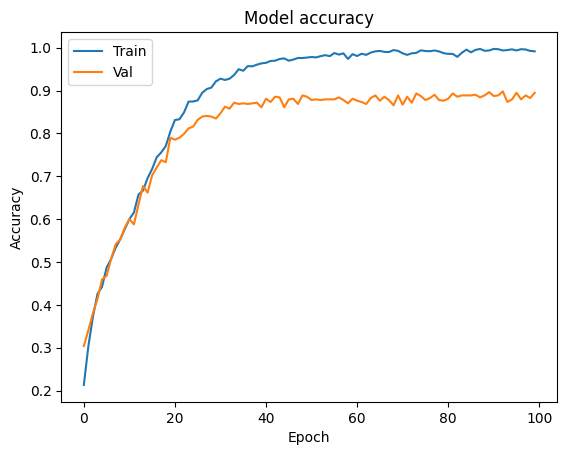

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

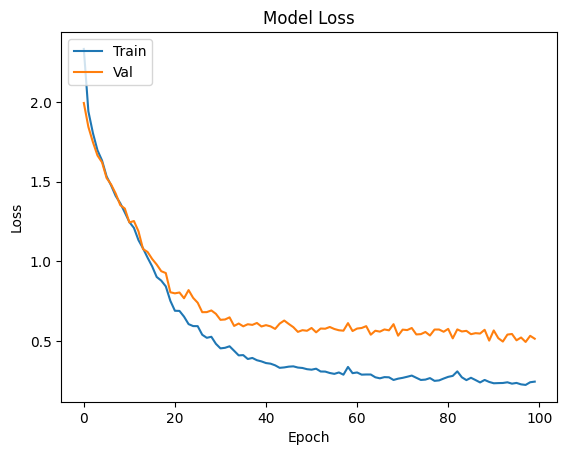

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(XTestProcessed)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


<Axes: >

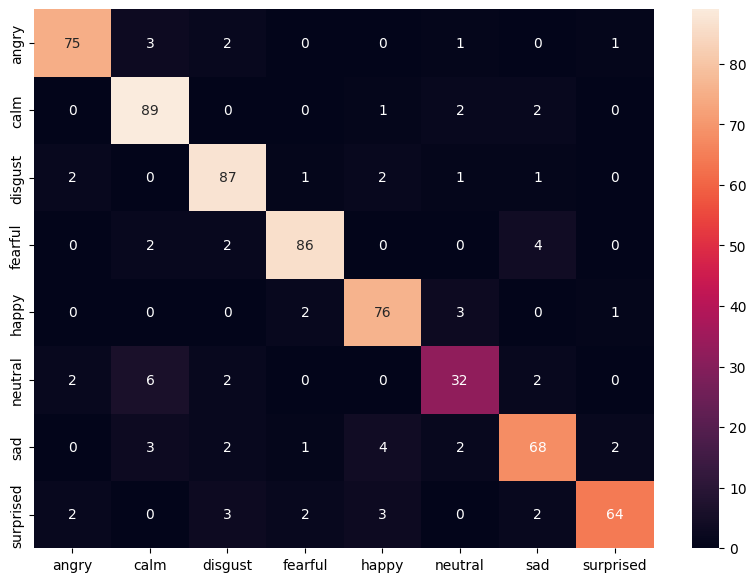

In [ ]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [ ]:
train_loss, train_acc = model.evaluate(XTrainProcessed, y_train, verbose=0)
val_loss, val_acc = model.evaluate(XValProcessed, y_val, verbose=0)
test_loss, test_acc = model.evaluate(XTestProcessed, y_test, verbose=0)

print(f"Train akurasi: {train_acc * 100:.2f}%")
print(f"Val akurasi: {val_acc * 100:.2f}%")
print(f"Test akurasi: {test_acc * 100:.2f}%")

Train akurasi: 100.00%
Val akurasi: 89.51%
Test akurasi: 89.04%


In [ ]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.8898902597076324

In [ ]:
print(f"Accuracy of the model: {history.history['accuracy'][-1]*100:.2f}%")

Accuracy of the model: 99.17%


# Save & Load Model

In [ ]:
# Save the trained model to disk
if not os.path.exists('models'):
    os.makedirs('models')

model.save("models/cnn.h5")

In [ ]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

# Uji Coba Model dengan Sample Data RAVDESS

In [ ]:
def predict_sample(file_path, model, labelencoder):
    """
    Fungsi untuk load file audio, mengekstrak fitur, melakukan prediksi, dan menampilkan hasilnya.
    """
    # Display audio player
    data, sr = librosa.load(file_path)
    print("Sample audio:")
    display(Audio(data, rate=sr))

    file_name = os.path.basename(file_path)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file_path)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    feature = np.expand_dims(feature, axis=0)
    feature = np.expand_dims(feature, axis=2)

    prediction = model.predict(feature)
    predicted_label = labelencoder.inverse_transform(np.argmax(prediction, axis=1))

    print("Label asli (dari nama file):", emotion_labels[int(file_name.split("-")[2])])
    print("Prediksi model:", predicted_label[0])

### Sample 1:

In [ ]:
predict_sample("speech_dataset/Actor_01/03-01-05-02-02-02-01.wav", model, labelencoder)

Sample audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Label asli (dari nama file): angry
Prediksi model: angry


### Sample 2:

In [ ]:
predict_sample("speech_dataset/Actor_02/03-01-03-01-01-01-02.wav", model, labelencoder)

Sample audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Label asli (dari nama file): happy
Prediksi model: happy


### Sample 3:

In [ ]:
predict_sample("speech_dataset/Actor_03/03-01-04-02-02-01-03.wav", model, labelencoder)

Sample audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Label asli (dari nama file): sad
Prediksi model: sad


### Sample 4:

In [ ]:
predict_sample("speech_dataset/Actor_04/03-01-01-01-02-01-04.wav", model, labelencoder)

Sample audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Label asli (dari nama file): neutral
Prediksi model: neutral


### Sample 5:

In [ ]:
predict_sample("speech_dataset/Actor_05/03-01-07-01-01-02-05.wav", model, labelencoder)

Sample audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Label asli (dari nama file): disgust
Prediksi model: disgust
